In [ ]:
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [ ]:
!os.getcwd()

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
%cd '/content/MyDrive/MyDrive/cnn/'
!ls

/content/MyDrive/MyDrive/cnn
0_aug_model_weights.hdf5  sub_blend009.csv	  submission54.csv
1_aug_model_weights.hdf5  sub.csv		  sub_TF_keras.csv
2_aug_model_weights.hdf5  sub_fcn.csv		  test.json
sample_submission.csv	  sub_keras_beginner.csv  test.json.7z
sample_submission.csv.7z  submission38.csv	  train.json
sub_200_ens_densenet.csv  submission43.csv	  train.json.7z


In [ ]:
#Path='/content/MyDrive/MyDrive/cnn/'
#!7z e 'sample_submission.csv.7z'
!7z e 'test.json.7z'
#!7z e 'train.json.7z'
!ls


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 257127394 bytes (246 MiB)

Extracting archive: test.json.7z
--
Path = test.json.7z
Type = 7z
Physical Size = 257127394
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./test.json
  Size:     1521771850 bytes (1452 MiB)
  Modified: 2017-10-23 17:27:23
with the file from archive:
  Path:     data/processed/test.json
  Size:     1521771850 bytes (1452 MiB)
  Modified: 2017-10-23 17:27:23
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content/MyDrive/MyDrive/cnn/"]).decode("utf8"))


# Any results you write to the current directory are saved as output.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [ ]:
#Load the data.
train = pd.read_json("/content/MyDrive/MyDrive/cnn/train.json")

In [ ]:
test = pd.read_json("/content/MyDrive/MyDrive/cnn/test.json")

In [ ]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [ ]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    fig.show(renderer="colab")
plotmy3d(X_band_1[12,:,:], 'iceberg')

In [ ]:
plotmy3d(X_band_1[14,:,:], 'Ship')

In [ ]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
#from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [ ]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [ ]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [ ]:
#Without denoising, core features.
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 128)       0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/50
51/51 [==============================] - 42s 805ms/step - loss: 0.8276 - accuracy: 0.5594 - val_loss: 0.5812 - val_accuracy: 0.6708
Epoch 2/50
51/51 [==============================] - 38s 739ms/step - loss: 0.5635 - accuracy: 0.6584 - val_loss: 0.5652 - val_accuracy: 0.7132
Epoch 3/50
51/51 [==============================] - 47s 918ms/step - loss: 0.5249 - accuracy: 0.7124 - val_loss: 0.4744 - val_accuracy: 0.7805
Epoch 4/50
51/51 [==============================] - 36s 691ms/step - loss: 0.4378 - accuracy: 0.7864 - val_loss: 0.4762 - val_accuracy: 0.8055
Epoch 5/50
51/51 [==============================] - 35s 678ms/step - loss: 0.4556 - accuracy: 0.7631 - val_loss: 0.4469 - val_accuracy: 0.8005
Epoch 6/50
51/51 [==============================] - 37s 718ms/step - loss: 0.4352 - accuracy: 0.8130 - val_loss: 0.3889 - val_accuracy: 0.8130
Epoch 7/50
51/51 [==============================] - 39s 772ms/step - loss: 0.4129 - accuracy: 0.8096 - val_loss: 0.4024 - val_accuracy: 0.8180

In [ ]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 2s 168ms/step - loss: 0.2726 - accuracy: 0.8753
Test loss: 0.2725788354873657
Test accuracy: 0.8753117322921753


In [ ]:
import keras

keras.models.Model.predict_proba = keras.models.Model.predict


X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

#y_prob = np.array(list(map(predict_prob, model_cEXT.predict(X_test))))
#y_prob 

264/264 [==============================] - 49s 183ms/step


In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

In [ ]:
print(submission)

            id    is_iceberg
0     5941774d  2.225232e-02
1     4023181e  8.191235e-01
2     b20200e4  9.787545e-01
3     e7f018bb  9.931690e-01
4     4371c8c3  7.922080e-01
...        ...           ...
8419  16ee9b50  2.562342e-23
8420  5a599eb7  4.745975e-01
8421  df30d6dd  4.395624e-02
8422  18af95b1  9.976166e-01
8423  27d788c8  9.312160e-01

[8424 rows x 2 columns]


In [ ]:
submission[(submission['is_iceberg']>=0.5)]

,id,is_iceberg
1,4023181e,0.819124
2,b20200e4,0.978754
3,e7f018bb,0.993169
4,4371c8c3,0.792208
7,92a51ffb,0.999572
...,...,...
8415,43db4207,0.861379
8417,ac96cfb0,0.872203
8418,fe45aef5,0.913716
8422,18af95b1,0.997617


In [ ]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [ ]:
#train = pd.read_json("../input/train.json")
target_train=train['is_iceberg']
#test = pd.read_json("../input/test.json")

In [ ]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)



X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.layers import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.layers import ELU, PReLU, LeakyReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input	

#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
def get_callbacks(filepath, patience=2):
   es = EarlyStopping('val_loss', patience=10, mode="min")
   msave = ModelCheckpoint(filepath, save_best_only=True)
   return [es, msave]


def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model([base_model.input, input_2], predictions)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model


#Using K-fold Cross Validation with Data Augmentation.
def myAngleCV(X_train, X_angle, X_test):
    K=3
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
    y_test_pred_log = 0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===================FOLD=',j)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        Y_holdout= target_train[test_idx]
        #Angle
        X_angle_cv=X_angle[train_idx]
        X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        file_path = "%s_aug_model_weights.hdf5"%j
        callbacks = get_callbacks(filepath=file_path, patience=5)
        gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
        galaxyModel= getVggAngleModel()
        galaxyModel.fit_generator(
                gen_flow,
                steps_per_epoch=24,
                epochs=100,
                shuffle=True,
                verbose=1,
                validation_data=([X_holdout,X_angle_hold], Y_holdout),
                callbacks=callbacks)

        #Getting the Best Model
        galaxyModel.load_weights(filepath=file_path)
        #Getting Training Score
        score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        #Getting validation Score.
        pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        temp_test=galaxyModel.predict([X_test, X_test_angle])
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

        #Getting Train Scores
        temp_train=galaxyModel.predict([X_train, X_angle])
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_test_pred_log=y_test_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
    print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    return y_test_pred_log

In [ ]:
preds=myAngleCV(X_train, X_angle, X_test)


===================FOLD= 0
58889256/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

<ipython-input-24-4ef5b045102e>:135: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
24/24 [==============================] - 360s 15s/step - loss: 0.6637 - accuracy: 0.6032 - val_loss: 0.4064 - val_accuracy: 0.7813
Epoch 2/100
24/24 [==============================] - 374s 15s/step - loss: 0.4348 - accuracy: 0.7831 - val_loss: 0.3152 - val_accuracy: 0.8374
Epoch 3/100
24/24 [==============================] - 354s 15s/step - loss: 0.3285 - accuracy: 0.8418 - val_loss: 0.2921 - val_accuracy: 0.8692
Epoch 4/100
24/24 [==============================] - 362s 15s/step - loss: 0.2748 - accuracy: 0.8761 - val_loss: 0.3143 - val_accuracy: 0.8523
Epoch 5/100
24/24 [==============================] - 353s 15s/step - loss: 0.2745 - accuracy: 0.8845 - val_loss: 0.2595 - val_accuracy: 0.8916
Epoch 6/100
24/24 [==============================] - 359s 15s/step - loss: 0.2474 - accuracy: 0.8932 - val_loss: 0.2560 - val_accuracy: 0.8860
Epoch 7/100
24/24 [==============================] - 363s 15s/step - loss: 0.2328 - accuracy: 0.9018 - val_loss: 0.2422 - val_accuracy: 0.9121

In [ ]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)

In [ ]:
submission

,id,is_iceberg
0,5941774d,0.071684
1,4023181e,0.337625
2,b20200e4,0.001252
3,e7f018bb,0.996767
4,4371c8c3,0.029243
...,...,...
8419,16ee9b50,0.000003
8420,5a599eb7,0.087389
8421,df30d6dd,0.033326
8422,18af95b1,0.985159


In [ ]:
Path = "/content/MyDrive/MyDrive/cnn"
all_files = os.listdir(Path)
all_files = all_files[1:3]
all_files.append('submission38.csv')
all_files.append('submission43.csv')
all_files

NameError: ignored

In [ ]:
# Read and concatenate submissions
out1 = pd.read_csv(Path+"/sub_200_ens_densenet.csv", index_col=0)
out2 = pd.read_csv(Path+"/sub_TF_keras.csv", index_col=0)
out3 = pd.read_csv(Path+"/submission38.csv", index_col=0)
out4 = pd.read_csv(Path+"/submission43.csv", index_col=0)
concat_sub = pd.concat([out1, out2, out3, out4], axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3
0,5941774d,1.943216e-02,0.005586,0.008875,0.005586
1,4023181e,3.168809e-02,0.145927,0.146779,0.031688
2,b20200e4,4.000000e-08,0.000015,0.048646,0.001000
3,e7f018bb,9.925741e-01,0.999914,0.999184,0.999000
4,4371c8c3,2.215107e-02,0.033843,0.277251,0.022151


In [ ]:
# check correlation
concat_sub.corr()

,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3
is_iceberg_0,1.000000,0.890434,0.986291,0.994880
is_iceberg_1,0.890434,1.000000,0.923848,0.900871
is_iceberg_2,0.986291,0.923848,1.000000,0.988002
is_iceberg_3,0.994880,0.900871,0.988002,1.000000


In [ ]:
# get the data fields ready for stacking
concat_sub['is_iceberg_max'] = concat_sub.iloc[:, 1:6].max(axis=1)
concat_sub['is_iceberg_min'] = concat_sub.iloc[:, 1:6].min(axis=1)
concat_sub['is_iceberg_mean'] = concat_sub.iloc[:, 1:6].mean(axis=1)
concat_sub['is_iceberg_median'] = concat_sub.iloc[:, 1:6].median(axis=1)

In [ ]:
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

In [ ]:
#concat_sub['is_iceberg'] = concat_sub['is_iceberg_mean']
#concat_sub[['id', 'is_iceberg']].to_csv('stack_mean.csv', index=False, float_format='%.6f')

In [ ]:
#concat_sub['is_iceberg'] = concat_sub['is_iceberg_median']
#concat_sub[['id', 'is_iceberg']].to_csv('stack_median.csv', index=False, float_format='%.6f'

In [ ]:
#concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:6] > cutoff_lo, axis=1), 1, 
#                                    np.where(np.all(concat_sub.iloc[:,1:6] < cutoff_hi, axis=1),
#                                             0, concat_sub['is_iceberg_median']))
#concat_sub[['id', 'is_iceberg']].to_csv('stack_pushout_median.csv', 
#                                        index=False, float_format='%.6f')

In [ ]:
#concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:6] > cutoff_lo, axis=1), 
#                                    concat_sub['is_iceberg_max'], 
#                                    np.where(np.all(concat_sub.iloc[:,1:6] < cutoff_hi, axis=1),
#                                             concat_sub['is_iceberg_min'], 
#                                             concat_sub['is_iceberg_mean']))
#concat_sub[['id', 'is_iceberg']].to_csv('stack_minmax_mean.csv', 
#                                        index=False, float_format='%.6f')

In [ ]:
#concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:6] > cutoff_lo, axis=1), 
#                                    concat_sub['is_iceberg_max'], 
#                                    np.where(np.all(concat_sub.iloc[:,1:6] < cutoff_hi, axis=1),
#                                             concat_sub['is_iceberg_min'], 
#                                             concat_sub['is_iceberg_median']))
#concat_sub['is_iceberg'] = np.clip(concat_sub['is_iceberg'].values, 0.001, 0.999)
#concat_sub[['id', 'is_iceberg']].to_csv('stack_minmax_median.csv', 
#                                       index=False, float_format='%.6f')

In [ ]:
# load the model with best base performance
sub_base = pd.read_csv(Path+'/submission43.csv')

In [ ]:
concat_sub['is_iceberg_base'] = sub_base['is_iceberg']
concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:4] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:4] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_base']))
concat_sub['is_iceberg'] = np.clip(concat_sub['is_iceberg'].values, 0.001, 0.999)
concat_sub[['id', 'is_iceberg']].to_csv('submission54.csv', 
                                        index=False, float_format='%.6f')

In [ ]:


# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf   
tf.random.set_seed(683)
# Uncomment this to hide TF warnings about allocation
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

In [ ]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [ ]:
train = pd.read_json(Path+"/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and 
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [ ]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band, images

In [ ]:

y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


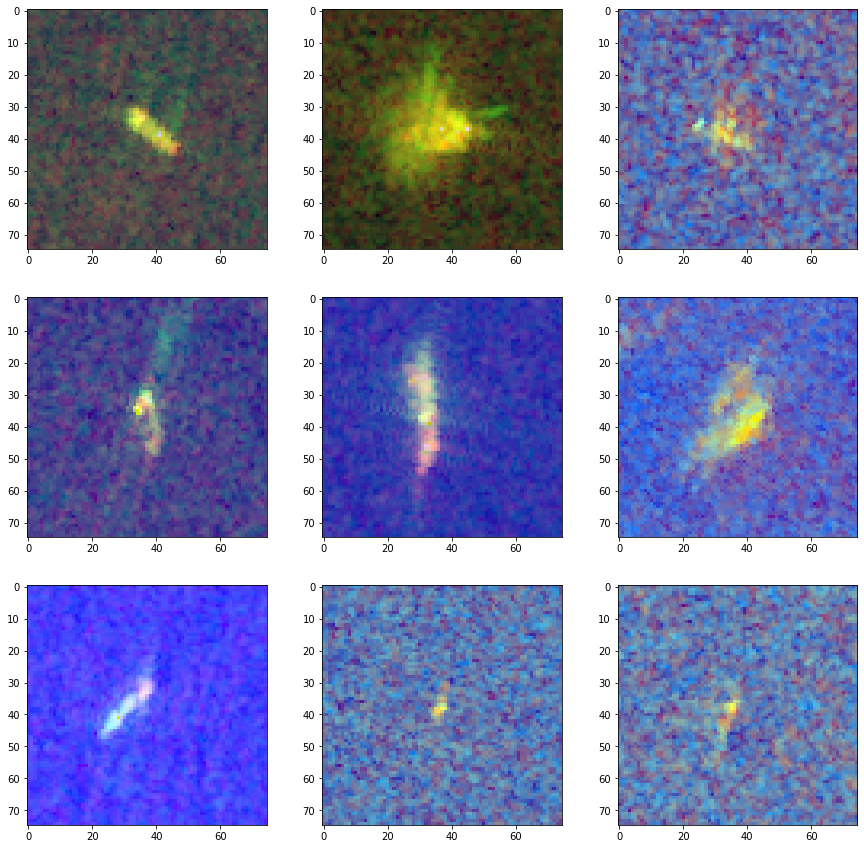

In [ ]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()


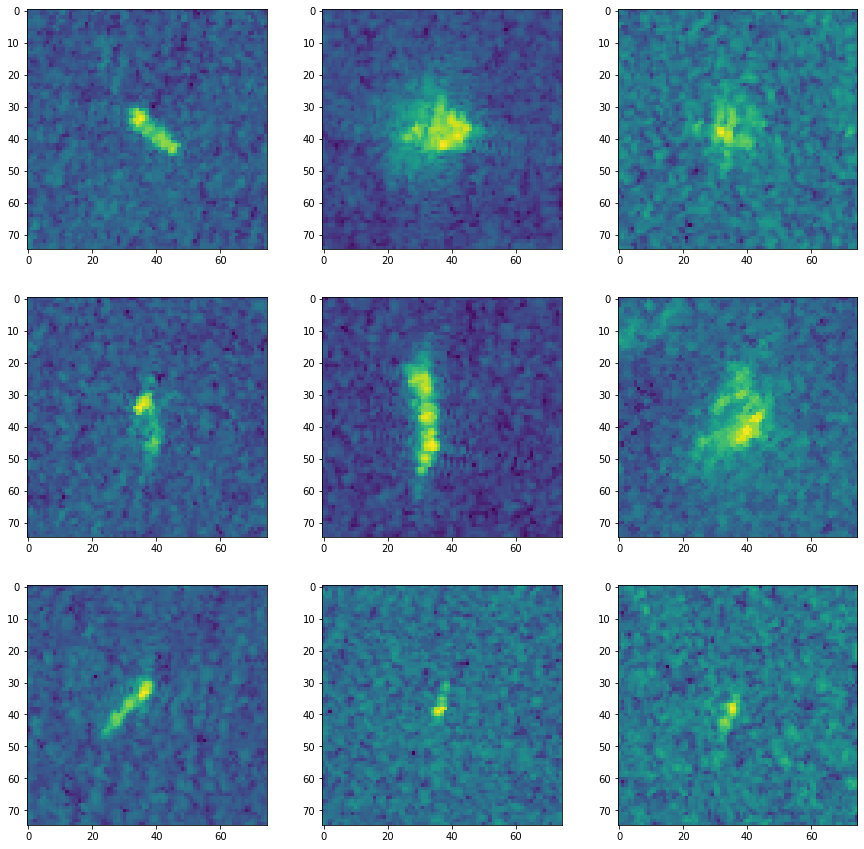

In [ ]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()


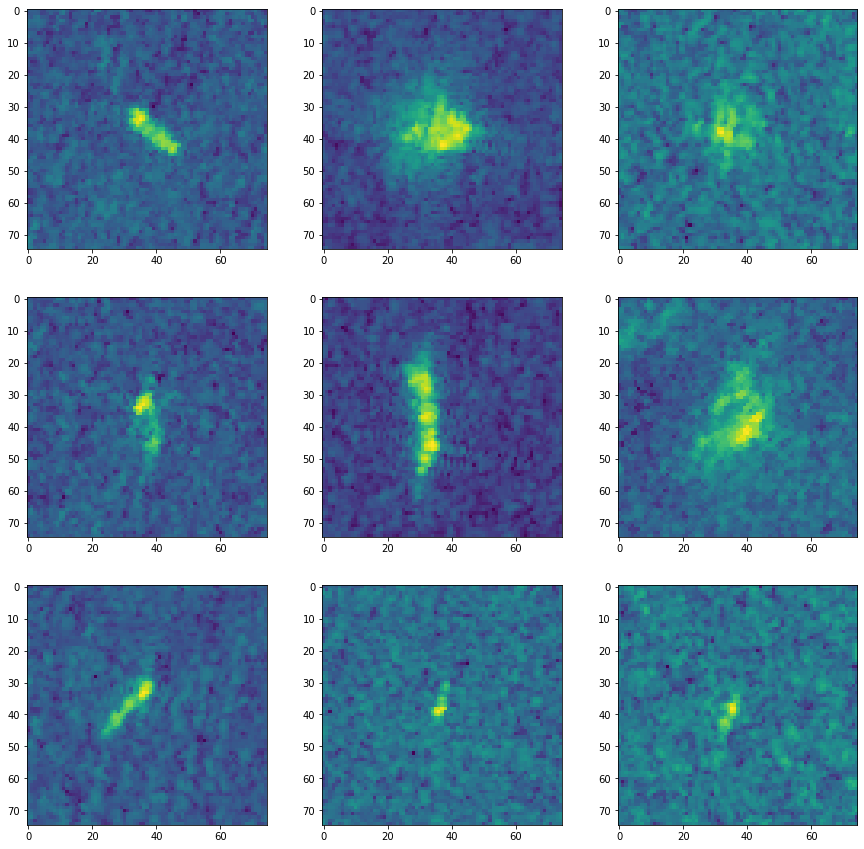

In [ ]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

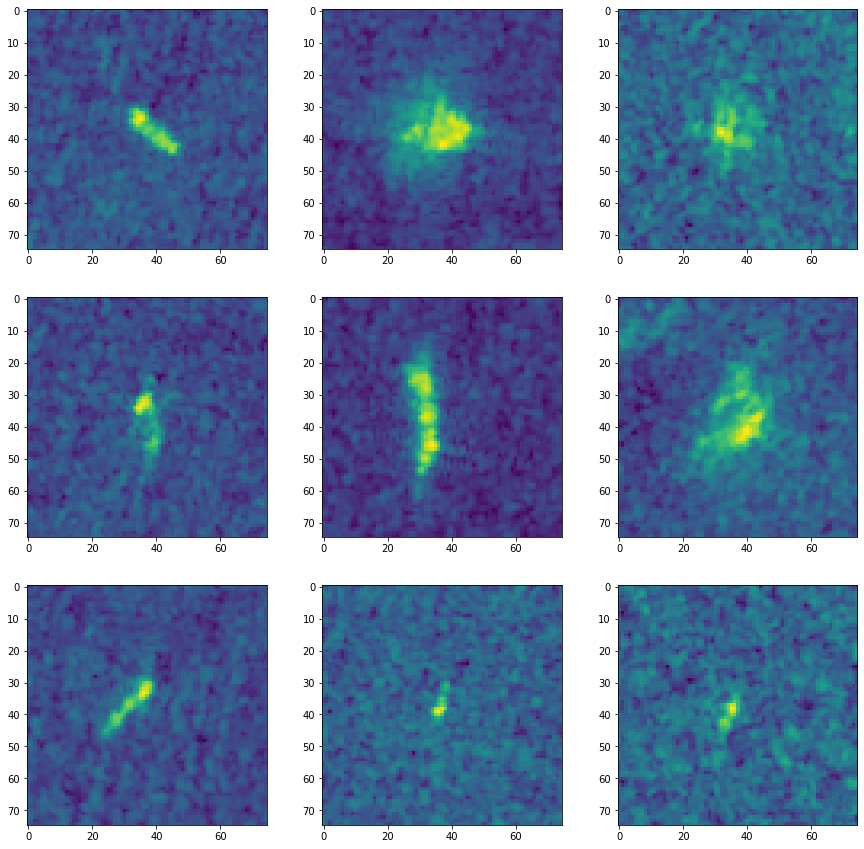

In [ ]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()


In [ ]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
def get_model_notebook(lr, decay, channels, relu_type='relu'):
  # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)

In [ ]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


In [ ]:

def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [ ]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [ ]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [ ]:
from tensorflow.python.ops.gen_array_ops import extract_image_patches_eager_fallback
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [ ]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json(Path+"/test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print('Done')

Reading test dataset
